In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [2]:
from simple_veloce_reduction import veloce_config, veloce_reduction_tools, veloce_extraction, veloce_logs, veloce_wavecalib

### Set up
It is done outside of my extraction function

In [3]:
run = "CSV_Run"
date = '230826'
arm = 'green'
amplifier_mode = 4
filename = '26aug20146.fits'
target = 'HD20203-USQ01'

In [4]:
config = {
    # primary information for the reduction
    'reduce': 'run',  # what to reduce options: 'run', 'night', or 'file'
    'run': 'CSV_Run',  # name of the run (directory name including observing nights - standard Veloce directory structure)
    'date': '230826',  # date of the observation (YYMMDD), if 'reduce' is 'night' or 'file'
    'filename': '26aug20146.fits',  # name of the file to reduce, if 'reduce' is 'file'
    'science_targets': 'targets.dat',  # file containing a list of science targets
    'calib_type': 'SimLC',  # Wavelength calibration to use SimLC, SimThXe (not implemented), Interpolate_lc (LC not implemented), Interpolate_th (Th, not implemented), or Static
    # secondary information for the reduction
    'arm': 'green',  # Which arm to reduce 'all', 'red', 'green' or 'blue'
    'amplifier_mode': 4,  # 2 or 4
    'sim_calib': True,  # Flag indicating if the simultaneous calibration was used True or False
    'plot_diagnostic': True,  # True or False
    'scattered_light': False,  # try to remove scattered light (background) True or False
    'flat_field': False,  # these are fiber flats (white light fiber spectrum) used for pixel sensitivity True or False

    # part responsible for the paths
    'input_dir': 'Data/Raw/CSV_Run',  # path to the directory with raw data (one in which the run directory is, i.e. input directory)
    'output_dir': 'Data/Extracted/Step-by-step',  # path to the directory where extracted data will be stored (i.e. output directory)

    # below are paths where code will store intermediate files and diagnostics
    # by default they are set as subdirectories of output directory with extracted data
    'master_dir': 'Default',  # directory for master images for night/run
    'wavelength_calibration_dir': 'Default',  # directory for wavelength calibration related files for the night/run
    'trace_shift_dir': 'Default',  # TODO: add to the code
    'plot_dir': 'Default',  # directory for diagnostic plots

    # below are paths where the code will look for internal files
    # leave as default unless you know what you are doing
    'trace_dir': 'Default',  # path to the directory with traces to be extracted
    'trace_file': 'Default',  # filename of the file with traces to be extracted
    'wave_dir': 'Default',  # path to the directory with reference wavelength solution
}

# veloce_paths = veloce_config.VelocePaths.from_config(config)
science_targets = veloce_config.load_target_list(config['science_targets'])

##### Directory structure <br>
It helps me pass all the paths between compnents but is less relevant in this step-by-step deminstration.<br>
I'm not quite happy of my approach to it but I hope it works.

In [ ]:
# output_path=os.path.join(os.getcwd(), 'Data', 'Extracted', 'Step-by-step') 
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

In [5]:
veloce_paths = veloce_config.VelocePaths.from_config(config)
# veloce_paths = veloce_config.VelocePaths(input_dir=f'./Data/Raw/{run}/', output_dir=f'./Data/Extracted/Step-by-step/')
# veloce_paths.__post_init__()

[Warning]: Output directory name: /home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Data/Extracted/Step-by-step,
 does not match run name: CSV_Run


In [6]:
obs_list = veloce_logs.load_night_logs(
            config['date'], config['science_targets'], config['arm'], veloce_paths)

### Begining of data extraction

All below happens in the extraction function:


In [7]:
# select correct dir name based on arm
if arm == 'blue':
    ccd = 'ccd_1'
elif arm == 'green':
    ccd = 'ccd_2'
elif arm == 'red':
    ccd = 'ccd_3'
else:
    raise ValueError('Unsupported arm')

Traces based on calibration fiber traces for ThAr from the manual to extract all expected orders.

In [8]:
trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(trace_filename)

Summing ranges are also derived from flats based on flux level above threshold which I dynamically set up for each order. <br>
Later tests showed that these need to be adujusted so the flux goes to zero to minimise noise. <br>
There is no reason to keep it like this in the final product, created an issue on github.

In [ ]:
# load spectrum
spectrum_filename = os.path.join(veloce_paths.input_dir, date, ccd, filename)
with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    hdr = hdul[0].header

removing overscan bias and merging the four quadrants.<br>
The gain(?) levels between quadrants doesn't seem to match. We spoke once about possible solution with Duncan.

In [11]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr, arm, amplifier_mode, overscan_range=32)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.0235340000000002
Gain for quadrant 3: 1.0256834214000001
Gain for quadrant 4: 1.012121


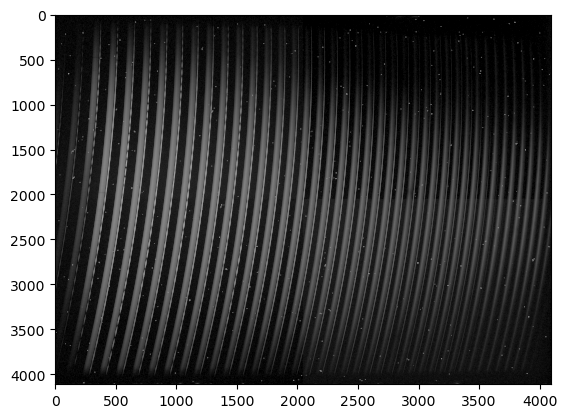

In [12]:
plt.imshow(image_subtracted_bias, aspect='auto', cmap='gray', norm='log')

Extracting orders based on the loaded traces.<br>
Below is a plot from my examination tool presenting cross section of extracted order. The extracted data is sum of counts from region between dashed lines (exclusive). I'm not ploting anything during bulk reduction.

In [13]:
if config['flat_field']:
    flat = veloce_extraction.get_flat(config, veloce_paths, arm, config['amplifier_mode'], config['date'], obs_list)
    image_subtracted_bias, hdr = veloce_reduction_tools.flat_field_correction(image_subtracted_bias, flat, hdr)

In [14]:
if config['scattered_light']:
    image_subtracted_bias, hdr = veloce_extraction.remove_scattered_light(image_subtracted_bias, hdr, traces)

In [15]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
        image_subtracted_bias, traces, remove_background=False)

array([[1.95401423, 0.97700711, 1.95401423, ..., 0.        , 0.        ,
        2.93102134],
       [1.95401423, 0.97700711, 1.95401423, ..., 2.93102134, 3.90802846,
        0.        ],
       [0.        , 2.93102134, 0.        , ..., 6.8390498 , 3.90802846,
        0.        ],
       ...,
       [1.98019802, 0.        , 3.96039604, ..., 7.92079208, 4.95049505,
        0.        ],
       [3.96039604, 3.96039604, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.97029703, 1.98019802, ..., 0.        , 0.99009901,
        1.98019802]])

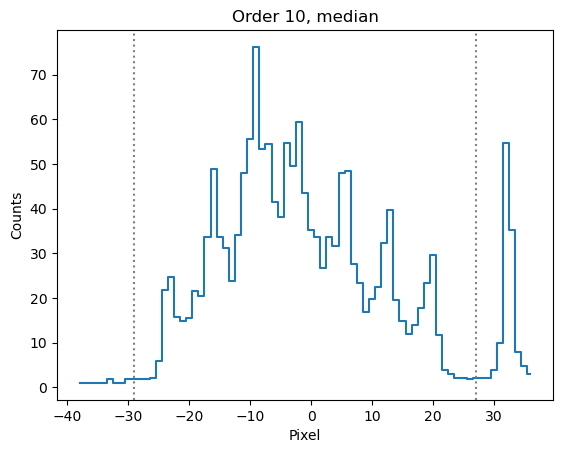

In [16]:
order = 10
veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, traces, order)

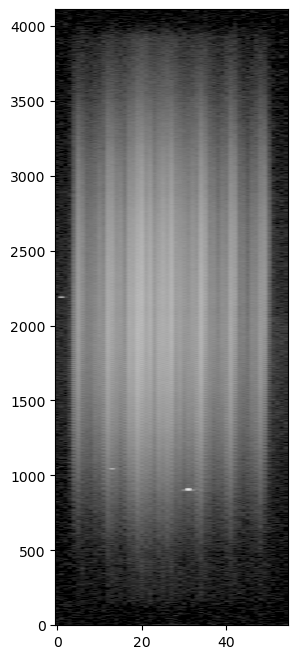

In [ ]:
order = 10
fig = plt.figure(figsize=(3, 8))
plt.imshow(extracted_order_imgs[order], aspect='auto', cmap='gray', norm='log', origin='lower')

Wave calibration based on the precomputed solution from Chris. There is one order offset between my traces and wave solutions (it is incomplete order and should be removed from traces for final version).

[Warning]: Reference LC and extracted LC do not have the same number of orders.
Amplitude: 3541046456.135046
 Shift: -0.020139054791154857
 Sigma: 0.8041102475597327
 Beta: 1.920641969016812
 Baseline: 258531815.78699774


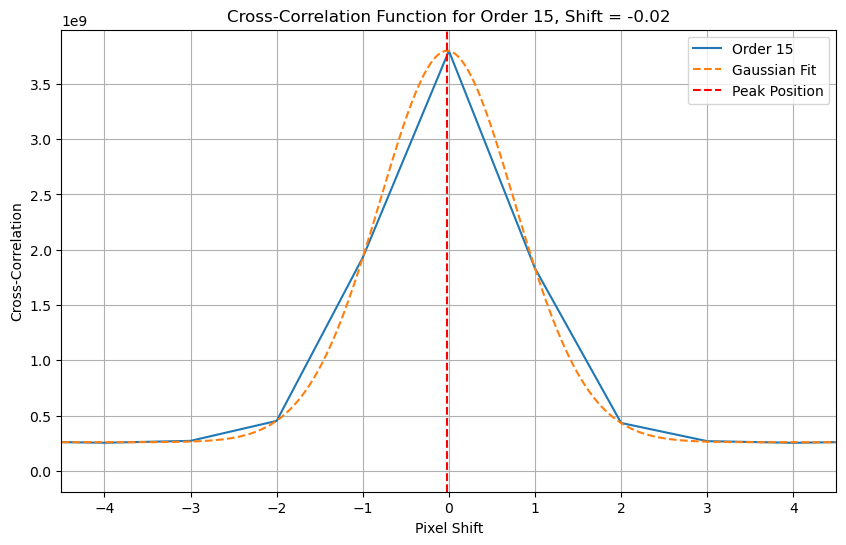

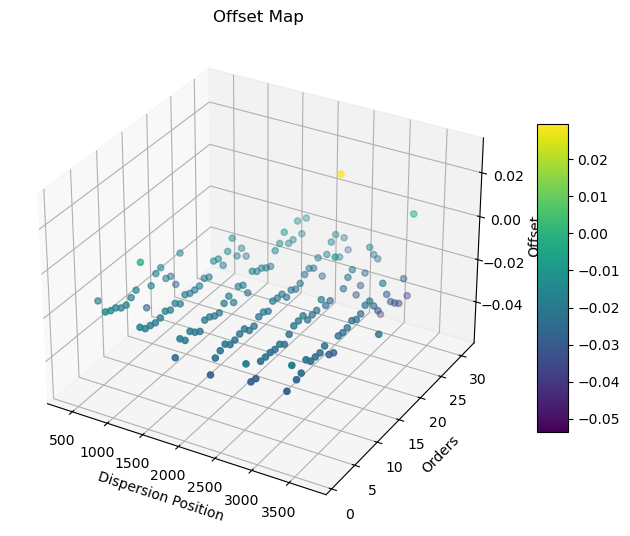

Calibration Precision estimated at 511nm: 5 m/s


In [18]:
if config['calib_type'] == 'Static':
    # load static wave calibration based on ThAr (from Chris Tinny)
    ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
        arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)
    vacuum_wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_science_orders, Y0, COEFFS, traces=traces)                   
    final_flux = extracted_science_orders
elif config['calib_type'] == 'SimLC':
    vacuum_wave, final_flux = veloce_wavecalib.calibrate_simLC(
                extracted_science_orders, veloce_paths, image_subtracted_bias,
                hdr, arm, plot=config['plot_diagnostic'])
final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]

In [21]:
# filename = os.listdir(veloce_paths.output_dir)[0]
# wave, flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(veloce_paths.output_path, filename))

Text(0, 0.5, 'Flux [ADU]')

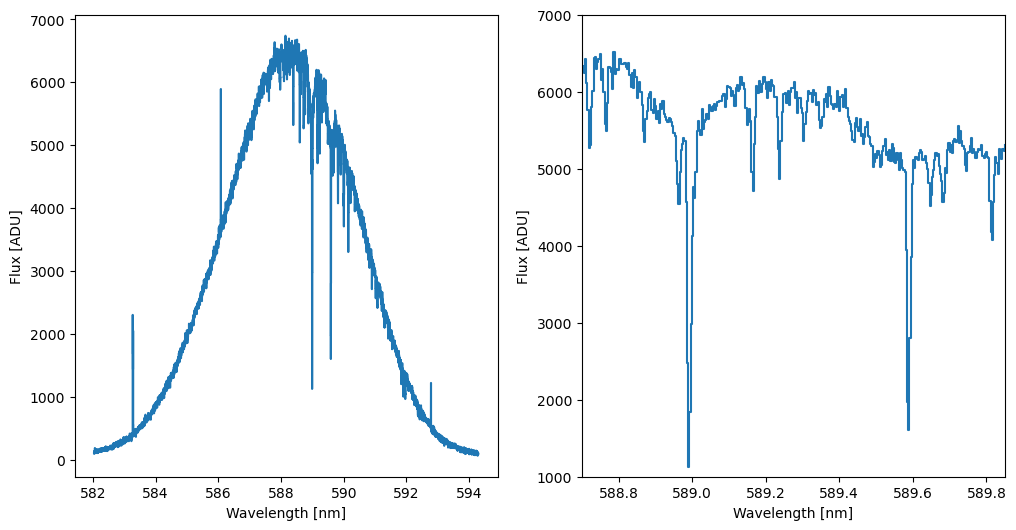

In [ ]:
order = 1
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].step(final_wave[order], final_flux[order], where='mid')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux [ADU]')
ax[1].step(final_wave[order], final_flux[order], where='mid')
plt.xlim(588.7, 589.85)
plt.ylim(1000, 7000)
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Flux [ADU]')

In [32]:
# save extracted spectrum as fits file
fits_filename = os.path.join(veloce_paths.output_dir, f"veloce_{arm}_{filename}")
veloce_reduction_tools.save_extracted_spectrum_fits(
    filename=fits_filename, wave=final_wave, flux=final_flux, hdr=hdr)

'/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Data/Extracted/Step-by-step/veloce_green_26aug20146.fits'